# Hybrid Multimodal Urban Routes

The focus of this activity is to evaluate the impacts of using Hybrid Urban Routing to a set trips identified in the city of São Paulo using the Twitter API. We collected geo-located tweets, anonymized them and in the present experiment we will cluster these tweets in order to identify trip flows. After this identification of flows we will evaluate the impacts in terms of price, duration and walking distance in the trips in case they were performed using hybrid routing.

## Record Linkage

The first step consists in linking the individual tweets into trips. To do so we will link all time-sequenced tweets from the same user and take them as trips. After this initial linkage, some filters are applied in order to keep only valid trips. For example, we consider valid trips only trips started and finished in the same day, bounded between 2 Km/h and 100 Km/h. Other filters were also used in the following code.


In [7]:
import os
import pandas as pd
from haversine import haversine

directory = 'data/anonym/'
file = 'twitter-sao-paulo.csv'

df = pd.read_csv(directory + file)
print('raw size: %d' % len(df))

if file == 'twitter-sp.csv':
    df['layer'] = 'twitter_sp'

df = df.sort_values(by=['uid', 'timestamp'], ascending=True)
df = pd.concat([df.add_suffix('_departure'), df.shift(-1).add_suffix('_arrival')], axis=1)

df = df[df.uid_departure == df.uid_arrival] # filtragem de usuário
print('user links filtered: %d' % len(df))

df['day_diff'] = df.apply(lambda r: abs(int(r.timestamp_arrival / 24 / 60 / 60) - int(r.timestamp_departure / 24 / 60 / 60)), axis=1)
df = df[df.day_diff == 0]
print('same day filtered: %d' % len(df)) #filtragem de dia

df['distance'] = df.apply(lambda r: haversine((r.lat_departure, r.lon_departure), (r.lat_arrival, r.lon_arrival)), axis=1)
df = df[df.distance > 0.1]
print('length filtered: %d' % len(df))

df = df[df.timestamp_arrival > df.timestamp_departure]
print('0s filtered: %d' % len(df))

df['speed'] = df.apply(lambda r: r.distance / (r.timestamp_arrival - r.timestamp_departure) * 60 * 60, axis=1)
df = df[(df.speed > 2) & (df.speed < 100)]
print('speed filtered: %d' % len(df))

# formating
df.drop(['layer_arrival', 'uid_arrival', 'day_diff'], axis=1, inplace=True)
df.rename({'layer_departure': 'layer', 'uid_departure': 'uid'}, axis=1, inplace=True)

if not os.path.exists('data/trips/'):
    os.makedirs('data/trips/')
df.to_csv('data/trips/' + file, index=False)

raw size: 690139
user links filtered: 588760
same day filtered: 94411
length filtered: 40612
0s filtered: 40567
speed filtered: 15675


## Clustering

Once the trips were linked, the next objective is to cluster the main flows in those trips. This is done due to the long time taken to evaluate routes. Using the main flows we can have an idea of the impacts of the hybrid routing without computing every route in the dataset.

In this step we use the [SMAFramework](https://github.com/diegopso/smaframework), a urban mobility analisys tool. This framework counts with an algorithm to identify main flows in a trip dataset. The algorithm uses [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan) algorithm to identify functional departure and arraival zones in the dataset; after it computes the flows between those zones and classify them in trending or secondary. 

The output is produced using Google Maps API, thus some keys must be configurated. In this section only Google Maps API is used, however we will configure all the keys. To do so, create a file called `.env` at the root of the project containing the API keys, like:


```
UBER_SERVER_TOKEN=your-key-here
GOOGLE_MAPS_KEY=your-key-here
TOMTOM_KEY=your-key-here
```



In [8]:
from smaframework.common.env import env
import smaframework.analyzer.clustering.flow as FlowClusterer

if not os.path.exists('data/results/'):
    os.makedirs('data/results/')

directory = 'data/trips/'
FlowClusterer.cluster_hdbscan(directory + file, ['lat_departure', 'lon_departure'], ['lat_arrival', 'lon_arrival'], output_file='data/results/%s' % file[0:-4], gmaps_key=env('GOOGLE_MAPS_KEY'), min_size=5)

INFO: running HDBSCAN
INFO: finished HDBSCAN with nclusters(origin=828, destination=839)
INFO: flow_thershold=28.000000 for file=data/results/twitter-sao-paulo


,lat_departure,lon_departure,lat_arrival,lon_arrival,flow
1435,-23.451383,-46.642510,-23.636349,-46.559957,65
1438,-23.451383,-46.642510,-23.519881,-46.680803,54
1622,-23.636992,-46.560095,-23.451480,-46.642543,76
1624,-23.636992,-46.560095,-23.565010,-46.626663,32
1625,-23.636992,-46.560095,-23.519881,-46.680803,60
1635,-23.627975,-46.555166,-23.558154,-46.608289,44
2840,-23.519900,-46.680837,-23.451480,-46.642543,63
2841,-23.519900,-46.680837,-23.636349,-46.559957,61
2842,-23.519900,-46.680837,-23.565010,-46.626663,52
2900,-23.565093,-46.626573,-23.636349,-46.559957,47


You can check the [Map Output](/view/data/results/twitter-sao-paulo.html) to visualize the flows identified.

## Routing

In this step, still making use of the SMAFramework to aid us, we will compute the routes for those flows. The idea is to combine routes to avoid traffic congestions, thus we will first compute a Driving Route for the flows using the [TomTom Routing API](https://developer.tomtom.com/), this API provide us some information abou the traffic conditions that can be used to improve the path. After collecting the driving ways we will compute the hybrid routes avoiding congested areas. To compute the routes we will use [Uber](https://developer.uber.com/) and [Google Directions](https://developers.google.com/maps/documentation/directions/start) API.

In [1]:
import json, datetime
import smaframework.extractor.tomtom.router as TomTomRouter
import smaframework.extractor.uber as UberExtractor
import smaframework.extractor.google.directions as GoogleDirectionsExtractor

def route(start, end):
    # transit pricing
    prices = {'TRANSIT': 4.30}

    # get driving way with traffic information
    driving_ways = TomTomRouter.getRoute(start, end, env('TOMTOM_KEY'), 0, True, False)
    
    # for each requested option
    for way in driving_ways:
        if 'sections' not in way.keys() or 'section' not in way['sections'].keys():
            continue

        # combine section to cover all traffic-avoidance options
        sections = way['sections']['section']
        if len(sections) > 0:
            combined_sections = []
            for (i, s1) in enumerate(sections):
                for (j, s2) in enumerate(sections):
                    if i >= j:
                        continue

                    combined_sections.append({
                      "sectionType": "TRAFFIC",
                      "effectiveSpeedInKmh": (float(s1['effectiveSpeedInKmh']) + float(s2['effectiveSpeedInKmh'])) / 2,
                      "delayInSeconds": s1['delayInSeconds'] + s2['delayInSeconds'],
                      "magnitudeOfDelay": max(s1['magnitudeOfDelay'], s2['magnitudeOfDelay']),
                      "effectiveSpeed": (s1['effectiveSpeed'] + s2['effectiveSpeed']) / 2,
                      "startPoint": s1['startPoint'],
                      "endPoint": s2['endPoint']
                    })
            sections.extend(combined_sections)

        # for each section with traffic, get some hybrid options
        options = []
        for section in sections:
            # evaluate an HPV started option
            transition = (section['startPoint']['@latitude'], section['startPoint']['@longitude'])
            estimate = UberExtractor.estimate(env('UBER_SERVER_TOKEN'), start, transition, 1, 'UberX')
            estimate['travel_mode'] = 'UberX'
            transit = GoogleDirectionsExtractor.extract_single(env('GOOGLE_MAPS_KEY'), transition, end, datetime.datetime.now(), 'transit', prices)
            option = [estimate]
            option.extend(transit[0])
            options.append(option)

            # evaluate an HPV ended option
            transition = (section['endPoint']['@latitude'], section['endPoint']['@longitude'])
            transit = GoogleDirectionsExtractor.extract_single(env('GOOGLE_MAPS_KEY'), start, transition, datetime.datetime.now(), 'transit', prices)
            estimate = UberExtractor.estimate(env('UBER_SERVER_TOKEN'), transition, end, 1, 'UberX')
            estimate['travel_mode'] = 'UberX'
            option = [estimate]
            option.extend(transit[0])
            options.append(option)

    full_hpv = [UberExtractor.estimate(env('UBER_SERVER_TOKEN'), start, end, 1, 'UberX')]
    full_hpv[0]['travel_mode'] = 'UberX'
    full_transit = GoogleDirectionsExtractor.extract_single(env('GOOGLE_MAPS_KEY'), start, end, datetime.datetime.now(), 'transit', prices)[0]
    options.extend([full_hpv, full_transit])
    
    return options
    
flows = json.load(open('data/results/twitter-sao-paulo.json', 'r+'))

for (i, flow) in enumerate(flows):
    start = (flow['link'][0]['lat'], flow['link'][0]['lng'])
    end = (flow['link'][1]['lat'], flow['link'][1]['lng'])
    #print(start,'\n',end)
    
    #flow['options'] = route(start, end)
    
    print('Options for flow %d computed.' % (i+1))

#json.dump(flows, open('data/results/options.json', 'w+'))

(-23.451382932919255, -46.64251048142858) 
 (-23.63634881783919, -46.55995690326633)
Options for flow 1 computed.
(-23.451382932919255, -46.64251048142858) 
 (-23.51988101282052, -46.6808026971795)
Options for flow 2 computed.
(-23.636991508232033, -46.560095243756905) 
 (-23.45147962123656, -46.642543184301076)
Options for flow 3 computed.
(-23.636991508232033, -46.560095243756905) 
 (-23.56500988, -46.626663209999975)
Options for flow 4 computed.
(-23.636991508232033, -46.560095243756905) 
 (-23.51988101282052, -46.6808026971795)
Options for flow 5 computed.
(-23.62797454923729, -46.55516570567797) 
 (-23.55815449185185, -46.608288526790126)
Options for flow 6 computed.
(-23.51989987440861, -46.68083652784948) 
 (-23.45147962123656, -46.642543184301076)
Options for flow 7 computed.
(-23.51989987440861, -46.68083652784948) 
 (-23.63634881783919, -46.55995690326633)
Options for flow 8 computed.
(-23.51989987440861, -46.68083652784948) 
 (-23.56500988, -46.626663209999975)
Options for f

All the options were evaluated and saved to the `data\results` folder.

## Visualization of Routes

Next, the algorithm shows the steps for generating 2D interactive maps. Initially, the algorithm initializes the map, which will be generated as output with the suggested route. Each section (also called step) of the route has a series of information, such as origin, destination, travel time, and the most important for generation of the visualization, the **overview polyline** and the **transport mode**. Then, the algorithm decodes the overview polyline and stores it in a coordinate list. Thus, the section is plotted on the map, where the line color is defined according to the transport mode. 

In [40]:
import math

from smaframework.common.env import env
from bs4 import BeautifulSoup as bs
from datetime import datetime
import googlemaps
import polyline as pline
import gmplot
import json


def Energy_Consumption(CA,Fconv,Fcorr):
    Fconv_value = ""
    Fcorr_value = ""
    F1_values = [["gasoline",0.770],["anhydrous alcohol",0.534],["hydrated alcohol",0.510],["diesel",0.848],["dry gas",0.880]] #Fconv
    F2_values = [["solid_liquid",0.95],["gas",0.90]] #Fcorr
    for i in F1_values:
        if i[0] == Fconv:
            Fconv_value = i[1]
    for i in F2_values:
        if i[0] == Fcorr:
            Fcorr_value = i[1]
    CC = CA * Fconv_value * Fcorr_value * 45.2 * math.pow(10,-3)
    return CC


def Carbon_Emission(CC,Femiss):
    Femiss_value = ""
    F_values = [["gasoline",18.9],["anhydrous alcohol",14.81],["hydrated alcohol",14.81],["diesel",20.2],["dry gas",15.3]] #Femiss
    for i in F_values:
        if i[0] == Femiss:
            Femiss_value = i[1]
    QC =  CC * Femiss_value * math.pow(10,-3)
    return QC


def CO2_Emission(EC):
    ECO2 = (EC * 44 / 12) * 1000 * 1000 # para retornar em Kg
    return ECO2

def GCC_EMISSION(CA,Fconv,Fcorr,Femiss):
    CC = Energy_Consumption(CA,Fconv,Fcorr)
    EC = Carbon_Emission(CC,Femiss)
    ECO2 = CO2_Emission(EC)
    return ECO2


colors = {}
colors["driving"]   = "blue"
colors["transit"]   = "red"
colors["walking"]   = "green"
colors["bicycling"] = "yellow"

gmaps = googlemaps.Client(key=env('GOOGLE_MAPS_KEY'))


def plotRoute(frm, to, travel_mode, fname):
    # Get a Google Maps directions (route) based on params and plot it in a HTML file.
    now = datetime.now()
    output_map = gmplot.GoogleMapPlotter(-23.551615, -46.633611, 12)    
    for i in range(len(frm)):
        route = gmaps.directions(frm[i], to[i],                                              
                            departure_time=now,
                            traffic_model="best_guess",
                            mode=travel_mode[i]                         
                            )

        # Save the route to use in the future.
        with open('data/results/maps/'+fname+'.json', 'a') as fileRoute:
            json.dump(route, fileRoute, indent=2)

        # If the overview polyline of each STEP were given as a parameter, the code should start HERE

        # Plot the route into the map
        path = pline.decode(route[0]['overview_polyline']['points'])
        lats = []
        lngs = []
        for step in path:
            step = list(step)       
            lats.append(step[0])
            lngs.append(step[1])
                
        output_map.plot(lats, lngs, colors[travel_mode[i]], edge_width=3)   
    url = 'data/results/maps/'+fname+'.html'
    output_map.draw(url)

    # Add the API key into html file
    page = open(url)
    soup = bs(page.read(),"html.parser")
    src = "https://maps.googleapis.com/maps/api/js?libraries=visualization&sensor=true_or_false"
    src_key  = "https://maps.googleapis.com/maps/api/js?key="
    src_key += env('GOOGLE_MAPS_KEY')
    src_key += "&libraries=visualization&sensor=true_or_false"
    line = soup.find('script',{'src':src})
    #line['src'] = line.replace(src, src_key)
    with open(url, "wb") as f_output:
        f_output.write(soup.prettify("utf-8"))  

    return


def read(fname):    
    with open(fname, 'r') as file:
        docs = json.load(file)
    return docs


def write(dist, wdist, price, duration, wait, emission, path):
    with open(path+'distance.json', 'w') as file:
        json.dump(dist, file)
    
    with open(path+'wdistance.json', 'w') as file:
        json.dump(wdist, file)
    
    with open(path+'price.json', 'w') as file:
        json.dump(price, file)
    
    with open(path+'duration.json', 'w') as file:
        json.dump(duration, file)
    
    with open(path+'wait.json', 'w') as file:
        json.dump(wait, file)
    
    with open(path+'emission.json', 'w') as file:
        json.dump(emission, file)
    return
        
    
def grab(docs):
    distance = {}
    walking_dist = {}
    price = {}
    duration = {}
    wait = {}
    emission = {}
    for i, doc in enumerate(docs):        
        for j, option in enumerate(doc["options"]):
            idx = str(i)+'-'+str(j)
            distance[idx] = 0
            walking_dist[idx] = 0
            price[idx]    = 0
            duration[idx] = 0
            wait[idx] = 0
            emission[idx] = 0
            frm = []
            to  = []
            mode = []
            for step in option:                
                frm.append(str(step["origin"][0])+','+str(step["origin"][1]))
                to.append(str(step["destination"][0])+','+str(step["destination"][1]))
                if step["travel_mode"] == "UberX": ##
                    m = "driving"
                    d = step["distance"]
                    d = ((d / 1000) / 12) / 1000 # considerando que a média é de 12 km por litro em cidade (carro)
                    emission[idx] += GCC_EMISSION(d,"gasoline","solid_liquid","gasoline")
                else:
                    m = str(step["travel_mode"].lower())
                mode.append(m)
                if m == "walking":
                    walking_dist[idx] += step["distance"]
                else:
                    distance[idx] += step["distance"]
                if m == "transit": ##
                    price[idx] += 4.25
                    d = step["distance"]
                    d = ((d / 1000) / 2.5) / 1000 # considerando que a média é de 2,5 km por litro (ônibus)
                    emission[idx] += GCC_EMISSION(d,"diesel","solid_liquid","diesel")
                else:
                    price[idx] += step["price"]
                duration[idx] += step["duration"]
                if "wait" in step:
                    wait[idx] += step["wait"]            
            plotRoute(frm, to, mode, str(i)+'-'+str(j)+'-routes')
    
    return distance, walking_dist, price, duration, wait, emission      
        
        
def worker():
    docs = read('data/results/options_manuscript.json')
    dist, wdist, price, duration, wait, emission = grab(docs)
    write(dist, wdist, price, duration, wait, emission, 'data/results/logs/')
        
if __name__ == '__main__':
    worker()        

You can check all interactive maps on [the maps folder](/tree/data/results/maps/).

## Comparative Analysis of Routes

With the logs calculated above, we can calculate the cost (in terms of distance, walking distance, duration, price and waiting time) of routes. We also can evaluate the average impact of the use of multimodal routes (Hybrid 1 and 2) in comparison to the traditional routes (Public Transport and Uber) in all flows studied.

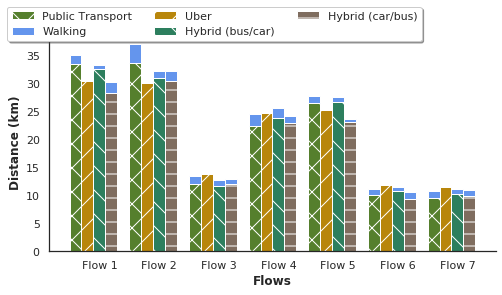

[0 1 2 3 4 5 6] [17.0, 17.0, 8.5, 12.75, 12.75, 8.5, 8.5]


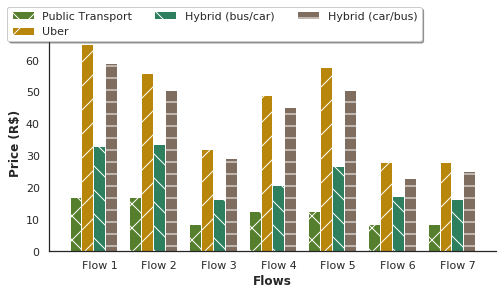

[0 1 2 3 4 5 6] [134.55, 108.55, 83.06666666666666, 107.13333333333334, 98.68333333333334, 62.083333333333336, 59.46666666666667]


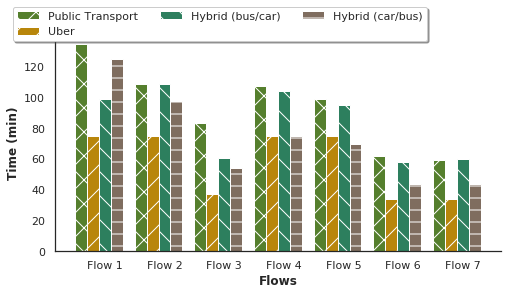

[0 1 2 3 4 5 6] [28.066666666666666, 32.666666666666664, 21.05, 12.783333333333333, 6.85, 5.666666666666667, 13.0]


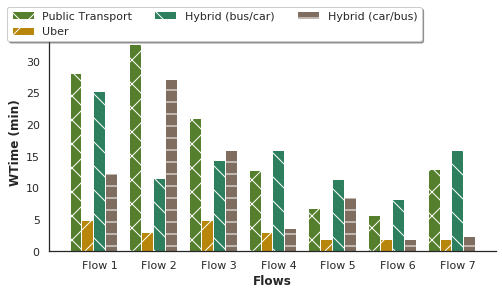

[0 1 2 3 4 5 6] [36.08691767680853, 36.363090315153066, 12.963932011665067, 24.180209046306132, 28.605444056029867, 10.869982437341868, 10.258303195383466]


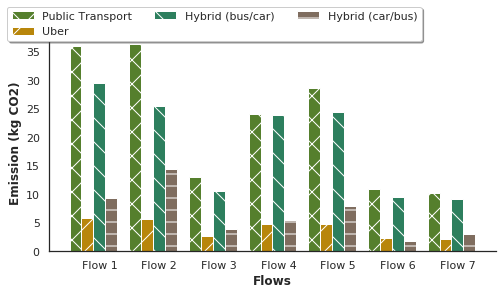

In [56]:
#%matplotlib notebook
#%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
import pandas as pd
import json

#### Results For each selected route ####

def plotResults(distance, wdistance, price, duration, wait, emission):
    keys = [['0-21','2-7','1-3','4-7','7-3','8-7','10-3'], #transit
            ['0-20','2-6','1-2','4-6','7-2','8-6','10-2'], #uber
            ['0-0','2-5','1-0','4-5','7-0','8-0','10-1'], #hyb1
            ['0-1','2-2','1-1','4-2','7-1','8-1','10-0']] #byb2

    labels = ['Public Transport', 'Uber', 'Hybrid (bus/car)', 'Hybrid (car/bus)']
    fluxos = ['Flow 1', 'Flow 2', 'Flow 3', 'Flow 4', 'Flow 5', 'Flow 6', 'Flow 7']
    
    bars1, bars2, bars3, bars4 = getData(distance, keys, 1000)
    wbars1, wbars2, wbars3, wbars4 = getData(wdistance, keys, 1000)
    plotDistance(bars1,bars2,bars3,bars4,wbars1,wbars2,wbars3,wbars4,'Distance (km)', labels, fluxos, 'distancia_fluxos.png')

    bars1, bars2, bars3, bars4 = getData(price, keys, 1)
    plotBars(bars1, bars2, bars3, bars4,'Price (R$)', labels, fluxos, 'preco_fluxos.png')

    bars1, bars2, bars3, bars4 = getData(duration, keys, 60)
    plotBars(bars1, bars2, bars3, bars4,'Time (min)', labels, fluxos, 'duracao_fluxos.png')

    bars1, bars2, bars3, bars4 = getData(wait, keys, 60)
    plotBars(bars1, bars2, bars3, bars4,'WTime (min)', labels, fluxos, 'espera_fluxos.png')
    
    bars1, bars2, bars3, bars4 = getData(emission, keys, 1)
    plotBars(bars1, bars2, bars3, bars4,'Emission (kg CO2)', labels, fluxos, 'emissao_fluxos.png')  

    return


def plotBars(bars1, bars2, bars3, bars4, ylabel, labels, fluxos, fname):
    # set width of bar
    barWidth = 0.2
    sns.set(style="white")

    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    
    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]
    
    # Plot bars chart
    plt.bar(r1, bars1, color='#557f2d', width=barWidth, edgecolor='white', label=labels[0],hatch=patterns[5])
    plt.bar(r2, bars2, color='#B8860B', width=barWidth, edgecolor='white', label=labels[1],hatch=patterns[0])
    plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label=labels[2],hatch=patterns[1])
    plt.bar(r4, bars4, color='#7f6d5f', width=barWidth, edgecolor='white', label=labels[3],hatch=patterns[3])
    
    print(r1,bars1)
    #plt.errorbar(r1, bars1,yerr=,solid_capstyle='projecting',linestyle='None',capsize=5, ecolor='black')
    #plt.errorbar(r2, bars2,yerr=,solid_capstyle='projecting',linestyle='None',capsize=5, ecolor='black')
    #plt.errorbar(r3, bars3,yerr=,solid_capstyle='projecting',linestyle='None',capsize=5, ecolor='black')
    #plt.errorbar(r4, bars4,yerr=,solid_capstyle='projecting',linestyle='None',capsize=5, ecolor='black')
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Flows', fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + 2*barWidth for r in range(len(bars1))], fluxos)
 
    # Create legend & Show graphic
    plt.legend(loc="upper center",bbox_to_anchor=(0.37,1.15),fancybox=True,shadow=True,ncol=3)
    
    sns.despine()
    plt.rcParams["figure.figsize"] = (8,4)
    
    #plt.savefig('data/results/plots/'+fname)
    plt.show()
    plt.close()
    return


def plotDistance(bars1,bars2,bars3,bars4,wbars1,wbars2,wbars3,wbars4,ylabel,labels,fluxos,fname):
    # set width of bar
    barWidth = 0.2
    sns.set(style="white")
    
    patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*" ]
    
    # Set position of bar on X axis
    r1 = np.arange(len(bars1))
    r2 = [x + barWidth for x in r1]
    r3 = [x + barWidth for x in r2]
    r4 = [x + barWidth for x in r3]

    plt.bar(r1, bars1, color='#557f2d', width=barWidth, edgecolor='white', label=labels[0],hatch=patterns[5])
    plt.bar(r1, wbars1, color='#6495ED', width=barWidth, bottom=bars1, edgecolor='white',label='Walking')
    plt.bar(r2, bars2, color='#B8860B', width=barWidth, edgecolor='white', label=labels[1],hatch=patterns[0])
    plt.bar(r2, wbars2, color='#6495ED', width=barWidth, bottom=bars2, edgecolor='white')
    plt.bar(r3, bars3, color='#2d7f5e', width=barWidth, edgecolor='white', label=labels[2],hatch=patterns[1])
    plt.bar(r3, wbars3, color='#6495ED', width=barWidth, bottom=bars3, edgecolor='white')
    plt.bar(r4, bars4, color='#7f6d5f', width=barWidth, edgecolor='white', label=labels[3],hatch=patterns[3])
    plt.bar(r4, wbars4, color='#6495ED', width=barWidth, bottom=bars4, edgecolor='white')
    
    
    # Add xticks on the middle of the group bars
    plt.xlabel('Flows', fontweight='bold')
    plt.ylabel(ylabel, fontweight='bold')
    plt.xticks([r + 2*barWidth for r in range(len(bars1))], fluxos)
    
    
    # Create legend & Show graphic
    plt.legend(loc="upper center",bbox_to_anchor=(0.37,1.15),fancybox=True,shadow=True,ncol=3)
    
    
    sns.despine()
    plt.rcParams["figure.figsize"] = (8,4)
    #plt.savefig('data/results/plots/' + fname, bbox_inches='tight')
    plt.show()
    plt.close()
    return


def getData(metric, keys, div):
    
    bars1 = [metric[key]/div for key in keys[0]]
    bars2 = [metric[key]/div for key in keys[1]]
    bars3 = [metric[key]/div for key in keys[2]]
    bars4 = [metric[key]/div for key in keys[3]]
    
    return bars1, bars2, bars3, bars4


def read(path):
    with open(path+'distance.json', 'r') as file:
        dist = json.load(file)
    
    with open(path+'wdistance.json', 'r') as file:
        wdist = json.load(file)
    
    with open(path+'price.json', 'r') as file:
        price = json.load(file)
    
    with open(path+'duration.json', 'r') as file:
        duration = json.load(file)
    
    with open(path+'wait.json', 'r') as file:
        wait = json.load(file)
        
    with open(path+'emission.json', 'r') as file:
        emission = json.load(file)
    
    return dist, wdist, price, duration, wait, emission


def worker():
    dist, wdist, price, duration, wait, emission = read('data/results/logs/')
    plotResults(dist, wdist, price, duration, wait, emission)
    
        
if __name__ == '__main__':
    worker()


In [12]:
import numpy as np
x = [17.0, 17.0, 8.5, 12.75, 12.75, 8.5, 8.5]
np.std(x)

3.5402207932989325

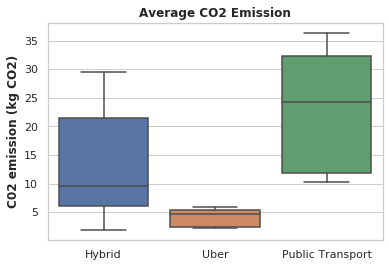

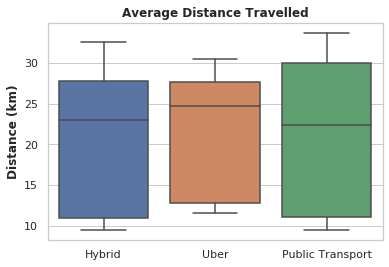

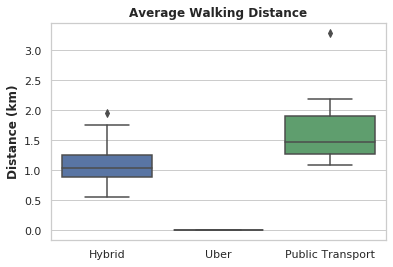

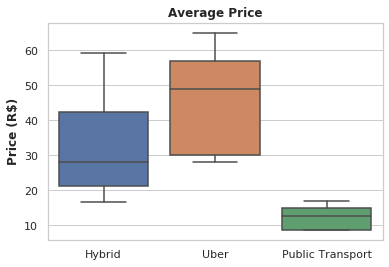

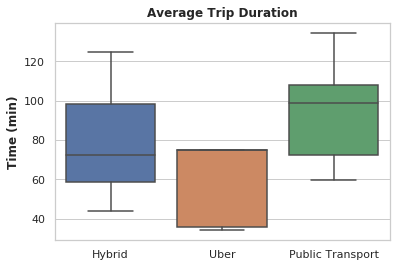

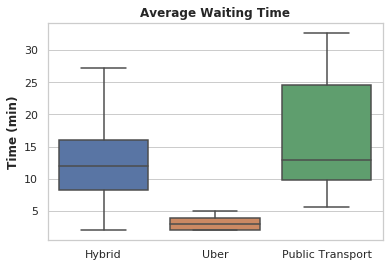

In [47]:
%matplotlib notebook
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import json

#### The average values of evaluated metrics ####
def plotResults(distance, wdistance, price, duration, wait, emission):
    transit_keys = ['0-21','2-7','1-3','4-7','7-3','8-7','10-3']
    
    uber_keys    = ['0-20','2-6','1-2','4-6','7-2','8-6','10-2']
    
    hybrid_keys  = ['0-0','2-5','1-0','4-5','7-0','8-0','10-1',
                    '0-1','2-2','1-1','4-2','7-1','8-1','10-0']
    # pseudo código:
    df = getDataFrame(emission, transit_keys, uber_keys, hybrid_keys,"C02 emission (kg CO2)", 1)
    plotBoxPlots(df, "C02 emission (kg CO2)" , 'avg_emissao.png', 'Average CO2 Emission')
    
    df = getDataFrame(distance, transit_keys, uber_keys, hybrid_keys,"Distance (km)", 1000)
    plotBoxPlots(df, "Distance (km)" , 'avg_distancia.png', 'Average Distance Travelled')

    df = getDataFrame(wdistance, transit_keys, uber_keys, hybrid_keys, "Distance (km)", 1000)
    plotBoxPlots(df, "Distance (km)" , 'avg_wdistancia.png', 'Average Walking Distance')

    df = getDataFrame(price, transit_keys, uber_keys, hybrid_keys, "Price (R$)", 1)
    plotBoxPlots(df, "Price (R$)" , 'avg_preco.png', 'Average Price')

    df = getDataFrame(duration, transit_keys, uber_keys, hybrid_keys, "Time (min)", 60)
    plotBoxPlots(df, "Time (min)" , 'avg_duracao.png', 'Average Trip Duration')

    df = getDataFrame(wait, transit_keys, uber_keys, hybrid_keys, "Time (min)", 60)
    plotBoxPlots(df, "Time (min)" , 'avg_wait.png', 'Average Waiting Time')
    
    return


def getDataFrame(metric, transit_keys, uber_keys, hybrid_keys, ylabel, div):
    data = []
    for key, value in metric.items():
        d = {}
        d["File"] = key
        d[ylabel] = value/div
        if key in transit_keys:
            d["Modo"] = "Public Transport"
            data.append(d)
        elif key in uber_keys:
            d["Modo"] = "Uber"
            data.append(d)
        elif key in hybrid_keys:
            d["Modo"] = "Hybrid"
            data.append(d)
        else:
            pass
    df = pd.DataFrame(data)
    
    return df


def plotBoxPlots(df, ylabel, fname, title):
    sns.set(style="whitegrid")
    ax = sns.boxplot(x="Modo", y=ylabel, data=df)
    plt.xlabel('')
    plt.ylabel(ylabel, fontweight='bold')
    plt.title(title,fontweight='bold')
    plt.savefig('data/results/plots/'+fname)
    plt.show()
    plt.close()

    return


def read(path):
    with open(path+'distance.json', 'r') as file:
        dist = json.load(file)
    
    with open(path+'wdistance.json', 'r') as file:
        wdist = json.load(file)
    
    with open(path+'price.json', 'r') as file:
        price = json.load(file)
    
    with open(path+'duration.json', 'r') as file:
        duration = json.load(file)
    
    with open(path+'wait.json', 'r') as file:
        wait = json.load(file)
        
    with open(path+'emission.json', 'r') as file:
        emission = json.load(file)
    
    return dist, wdist, price, duration, wait, emission


def worker():
    dist, wdist, price, duration, wait, emission = read('data/results/logs/')
    plotResults(dist, wdist, price, duration, wait, emission)
    
        
if __name__ == '__main__':
    worker()

## Discussion and Final Remarks

The work "[Hybrid Context-Aware Multimodal Routing](https://doi.org/10.1109/ITSC.2018.8570008)" performs experiments similar to those performed here, where the scenario used is the city of New York, NY, USA, and propose an optimization function to calculate the user experience according to the same metrics presented in this section, in order to support the decision-making process. Here, we have chosen to present and analyze two examples of multimodal routes beyond traditional routes. However, the only selection criteria of the multimodal routes was their composition, beign the two extremes (i.e., one being mostly with the Uber transport medium and the other with Public Transport), but none of the metrics were used individually (e.g., the lowest price multimodal route or trip duration) or together (e.g., the lowest price route and the shortest walking distance) to select these routes. If the reader intends to select the "best" multimodal routes to be compared with the traditional routes, multiobjective optimization methods must be explored and incorporated into the application.